<a href="https://colab.research.google.com/github/Tumars-web/E-commerce-user-growth-analysis/blob/main/notebooks/06_%E7%94%A8%E6%88%B7%E7%95%99%E5%AD%98%E8%B6%8B%E5%8A%BF%E4%B8%8E%E5%88%86%E7%BE%A4%E5%AF%B9%E6%AF%94%E5%88%86%E6%9E%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import zipfile
import urllib.request
import matplotlib.pyplot as plt
import seaborn as sns


url = 'https://github.com/Tumars-web/E-commerce-user-growth-analysis/raw/main/cleaned_data.csv.zip'
zip_path = 'cleaned_data.zip'

# 下载压缩包
urllib.request.urlretrieve(url, zip_path)

# 解压缩
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()

# 读取 CSV
df = pd.read_csv('cleaned_data.csv')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

print("数据加载成功！")
df.head()

数据加载成功！


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [3]:
# 1. 生成 Cohort 留存表
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['CohortMonth'] = df.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')
df['OrderMonth'] = df['InvoiceDate'].dt.to_period('M')
df['CohortIndex'] = (df['OrderMonth'] - df['CohortMonth']).apply(lambda x: x.n)

cohort_data = df.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].nunique().reset_index()
initial_counts = cohort_data[cohort_data['CohortIndex'] == 0][['CohortMonth', 'CustomerID']]
initial_counts.columns = ['CohortMonth', 'TotalUsers']
cohort_data = cohort_data.merge(initial_counts, on='CohortMonth')
cohort_data['RetentionRate'] = cohort_data['CustomerID'] / cohort_data['TotalUsers']
retention = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='RetentionRate')

#用于查看 retention 表是否成功
print(retention.head())


CohortIndex   0         1         2         3         4         5         6   \
CohortMonth                                                                    
2010-12      1.0  0.366102  0.323164  0.384181  0.362712  0.397740  0.362712   
2011-01      1.0  0.220624  0.266187  0.230216  0.321343  0.287770  0.247002   
2011-02      1.0  0.186842  0.186842  0.284211  0.271053  0.247368  0.252632   
2011-03      1.0  0.150442  0.252212  0.199115  0.223451  0.168142  0.267699   
2011-04      1.0  0.213333  0.203333  0.210000  0.196667  0.226667  0.216667   

CohortIndex        7         8         9         10        11        12  
CohortMonth                                                              
2010-12      0.349153  0.353672  0.395480  0.374011  0.502825  0.265537  
2011-01      0.242206  0.299760  0.326139  0.364508  0.117506       NaN  
2011-02      0.278947  0.247368  0.305263  0.068421       NaN       NaN  
2011-03      0.230088  0.278761  0.086283       NaN       NaN       N

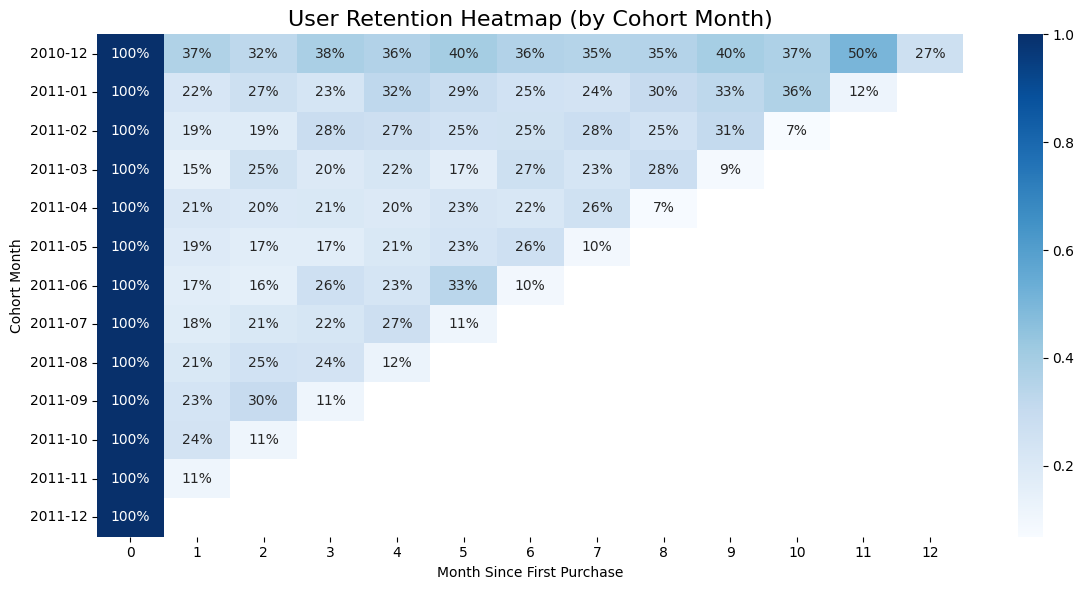

In [4]:
# 例：热力图
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(retention, annot=True, fmt=".0%", cmap="Blues")
plt.title("User Retention Heatmap (by Cohort Month)", fontsize=16)
plt.xlabel("Month Since First Purchase")
plt.ylabel("Cohort Month")
plt.tight_layout()
plt.show()


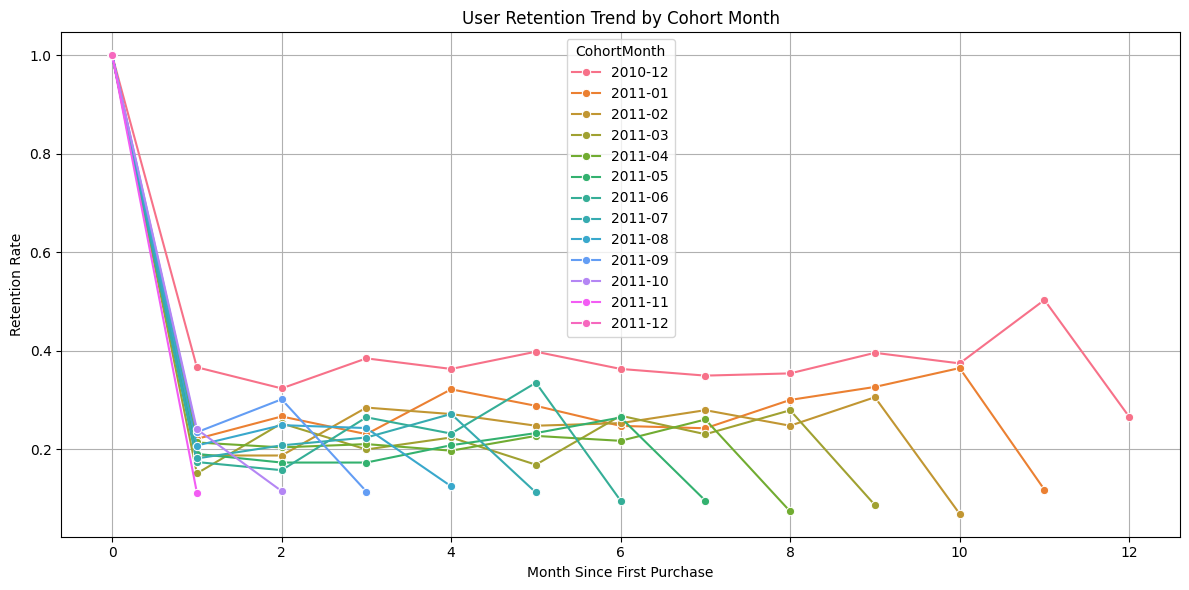

In [5]:
#折线图留存趋势
retention_reset = retention.reset_index().melt(id_vars='CohortMonth', var_name='CohortIndex', value_name='RetentionRate')
retention_reset['CohortIndex'] = retention_reset['CohortIndex'].astype(int)

plt.figure(figsize=(12, 6))
sns.lineplot(data=retention_reset, x='CohortIndex', y='RetentionRate', hue='CohortMonth', marker='o')
plt.title('User Retention Trend by Cohort Month')
plt.xlabel('Month Since First Purchase')
plt.ylabel('Retention Rate')
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
# 每行订单金额
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# 截止分析时间点（通常是数据中最后一天+1）
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# 构建 RFM 值
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # R
    'InvoiceNo': 'nunique',                                   # F
    'TotalPrice': 'sum'                                       # M
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
print(rfm.head())

   CustomerID  Recency  Frequency  Monetary
0       12346      326          1  77183.60
1       12347        2          7   4310.00
2       12348       75          4   1797.24
3       12349       19          1   1757.55
4       12350      310          1    334.40


In [7]:
import numpy as np

def cut_score(series, bins=4, ascending=True):
    # 生成等距区间分箱，适合数据分布不均的情况
    labels = list(range(1, bins + 1))
    if ascending:
        labels = labels[::-1]
    return pd.cut(series, bins=bins, labels=labels, include_lowest=True)

rfm['R_Score'] = cut_score(rfm['Recency'], bins=4, ascending=True)
rfm['F_Score'] = cut_score(rfm['Frequency'], bins=4, ascending=False)
rfm['M_Score'] = cut_score(rfm['Monetary'], bins=4, ascending=False)

# 合并成 RFM Score 字符串
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# 定义 RFM 分群规则（简单示例）
def rfm_level(score):
    if score >= '444':
        return 'Best'
    elif score >= '344':
        return 'Loyal'
    elif score >= '244':
        return 'Potential'
    else:
        return 'At Risk'

rfm['RFM_Level'] = rfm['RFM_Score'].apply(rfm_level)
print(rfm[['Recency','Frequency','Monetary']].head())
print(rfm[['Recency','Frequency','Monetary']].describe())


   Recency  Frequency  Monetary
0      326          1  77183.60
1        2          7   4310.00
2       75          4   1797.24
3       19          1   1757.55
4      310          1    334.40
           Recency    Frequency       Monetary
count  4338.000000  4338.000000    4338.000000
mean     92.536422     4.272015    2054.266460
std     100.014169     7.697998    8989.230441
min       1.000000     1.000000       3.750000
25%      18.000000     1.000000     307.415000
50%      51.000000     2.000000     674.485000
75%     142.000000     5.000000    1661.740000
max     374.000000   209.000000  280206.020000


In [8]:
import pandas as pd

def safe_qcut(series, q=4, ascending=True):
    try:
        bins = pd.qcut(series, q=q, duplicates='drop')
        actual_bins = bins.cat.categories.size
        labels = list(range(1, actual_bins + 1))
        if ascending:
            labels = labels[::-1]
        return pd.qcut(series, q=actual_bins, labels=labels, duplicates='drop')
    except Exception as e:
        print("qcut failed:", e)
        # 返回所有为1的Series，长度与输入相同
        return pd.Series([1]*len(series), index=series.index)

# 测试
print("Recency分布:\n", rfm['Recency'].value_counts())
print("Frequency分布:\n", rfm['Frequency'].value_counts())
print("Monetary分布:\n", rfm['Monetary'].value_counts())

rfm['R_Score'] = safe_qcut(rfm['Recency'], q=4, ascending=True)
print("R_Score示例:\n", rfm['R_Score'].head())

rfm['F_Score'] = safe_qcut(rfm['Frequency'], q=4, ascending=False)
print("F_Score示例:\n", rfm['F_Score'].head())

rfm['M_Score'] = safe_qcut(rfm['Monetary'], q=4, ascending=False)
print("M_Score示例:\n", rfm['M_Score'].head())


Recency分布:
 Recency
4      111
1       93
3       89
2       86
8       76
      ... 
314      1
164      1
322      1
160      1
258      1
Name: count, Length: 349, dtype: int64
Frequency分布:
 Frequency
1      1493
2       835
3       508
4       388
5       242
6       172
7       143
8        98
9        68
10       54
11       52
12       45
13       30
15       28
14       20
17       18
18       14
20       12
19       12
16       11
21       11
25        8
26        7
28        6
23        5
22        5
30        4
24        3
37        3
31        3
32        3
34        3
27        3
47        2
55        2
33        2
39        2
38        2
209       1
62        1
35        1
86        1
97        1
93        1
44        1
50        1
57        1
48        1
41        1
201       1
73        1
63        1
91        1
29        1
51        1
46        1
124       1
45        1
60        1
Name: count, dtype: int64
Monetary分布:
 Monetary
76.32      4
15.00      3
363.65     3
3

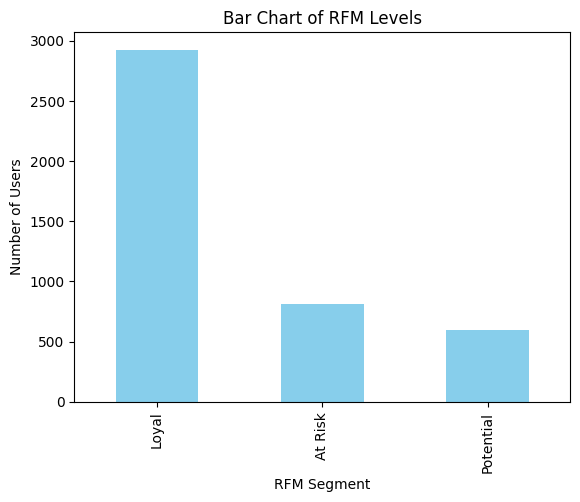

In [10]:
#用户分群可视化

import matplotlib.pyplot as plt
import seaborn as sns

rfm['RFM_Level'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Bar Chart of RFM Levels')
plt.xlabel('RFM Segment')
plt.ylabel('Number of Users')
plt.show()


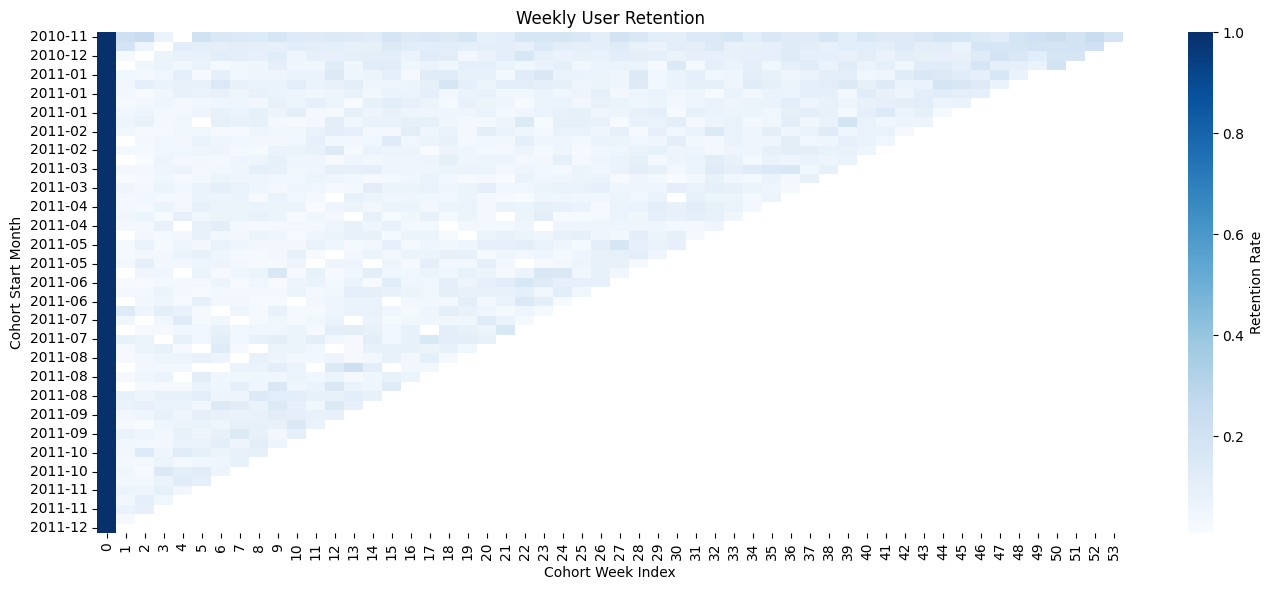

In [18]:
#创建留存矩阵
# Step 1: 预处理
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['cohort'] = df.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('W').dt.start_time
df['order_week'] = df['InvoiceDate'].dt.to_period('W').dt.start_time
df['cohort_index'] = ((df['order_week'] - df['cohort']) / np.timedelta64(1, 'W')).astype(int)

# Step 2: 留存人数
cohort_data = df.groupby(['cohort', 'cohort_index'])['CustomerID'].nunique().reset_index()
cohort_pivot = cohort_data.pivot(index='cohort', columns='cohort_index', values='CustomerID')

# Step 3: 留存率矩阵
cohort_size = cohort_pivot.iloc[:, 0]
# 设置格式清晰的 cohort 日期（只保留年月）
retention.index = pd.to_datetime(retention.index).strftime('%Y-%m')


# 重新绘图（不显示每格的具体数字，专注整体趋势）
plt.figure(figsize=(14, 6))
sns.heatmap(retention, cmap='Blues', annot=False, fmt='.0%', cbar_kws={'label': 'Retention Rate'})
plt.title('Weekly User Retention')
plt.xlabel('Cohort Week Index')
plt.ylabel('Cohort Start Month')
plt.tight_layout()
plt.show()


In [31]:
#分群对比留存

# 1. 查看两个 DataFrame 的列，确认关键列名
print("df columns:", df.columns)
print("rfm columns:", rfm.columns)

# 2. 如果 rfm 有多层索引，先重置索引（防止重复列名）
#    这里用 drop=True 避免生成 level_0 列冲突
rfm = rfm.reset_index(drop=True)

# 3. 确认 df 和 rfm 都有 'CustomerID' 这一列，且列名一致
assert 'CustomerID' in df.columns, "df 缺少 CustomerID 列"
assert 'CustomerID' in rfm.columns, "rfm 缺少 CustomerID 列"

# 4. 如果 df 里有跟 rfm 合并时会冲突的列（比如 RFM_Level，RFM_Level_x，RFM_Level_y），先删除
cols_to_drop = [col for col in ['RFM_Level', 'RFM_Level_x', 'RFM_Level_y'] if col in df.columns]
if cols_to_drop:
    print(f"Deleting columns from df to avoid merge conflict: {cols_to_drop}")
    df = df.drop(columns=cols_to_drop)

# 5. 执行合并，避免后缀冲突
df = df.merge(rfm[['CustomerID', 'RFM_Level']], on='CustomerID', how='left')

# 6. 合并完成后，查看 df 的新结构确认是否正确
print("df columns after merge:", df.columns)
print(df.head())


df columns: Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'CohortMonth', 'OrderMonth',
       'CohortIndex', 'TotalPrice', 'cohort', 'order_week', 'cohort_index',
       'RFM_Level_x', 'RFM_Level_y'],
      dtype='object')
rfm columns: Index(['level_0', 'index', 'CustomerID', 'Recency', 'Frequency', 'Monetary',
       'R_Score', 'F_Score', 'M_Score', 'RFM_Score', 'RFM_Level'],
      dtype='object')
Deleting columns from df to avoid merge conflict: ['RFM_Level_x', 'RFM_Level_y']
df columns after merge: Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'CohortMonth', 'OrderMonth',
       'CohortIndex', 'TotalPrice', 'cohort', 'order_week', 'cohort_index',
       'RFM_Level'],
      dtype='object')
   InvoiceNo StockCode                          Description  Quantity  \
0     536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    

In [32]:
import pandas as pd

# 1. 先确保日期列是 datetime 格式
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# 2. 计算每个用户的首单日期 cohort，按周或月分
df['cohort_week'] = df.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('W').dt.start_time

# 3. 计算用户当周与首单周的周差（即留存周期周数）
df['order_week'] = df['InvoiceDate'].dt.to_period('W').dt.start_time
df['weeks_since_cohort'] = ((df['order_week'] - df['cohort_week']).dt.days / 7).astype(int)

# 4. 按 cohort_week、RFM_Level、weeks_since_cohort 分组统计不同用户数（去重）
retention = df.groupby(['cohort_week', 'RFM_Level', 'weeks_since_cohort'])['CustomerID'].nunique().reset_index()

# 5. 透视表展示留存情况
retention_pivot = retention.pivot_table(
    index=['cohort_week', 'RFM_Level'],
    columns='weeks_since_cohort',
    values='CustomerID'
)

print(retention_pivot.head(10))


weeks_since_cohort        0     1     2     3     4     5     6     7     8   \
cohort_week RFM_Level                                                          
2010-11-29  At Risk     70.0   4.0   6.0   1.0   NaN   7.0   4.0   2.0   3.0   
            Loyal      209.0  59.0  65.0  19.0   NaN  49.0  42.0  42.0  38.0   
            Potential   24.0   2.0   2.0   NaN   NaN   4.0   1.0   1.0   1.0   
2010-12-06  At Risk     69.0   5.0   NaN   NaN   4.0   1.0   3.0   1.0   4.0   
            Loyal      245.0  55.0  17.0   NaN  36.0  34.0  28.0  38.0  30.0   
            Potential   27.0   3.0   3.0   NaN   1.0   NaN   3.0   NaN   1.0   
2010-12-13  At Risk     40.0   2.0   NaN   1.0   NaN   1.0   1.0   4.0   3.0   
            Loyal      135.0   3.0   NaN   9.0  15.0  15.0  21.0  17.0  12.0   
            Potential   25.0   NaN   NaN   3.0   2.0   1.0   2.0   NaN   3.0   
2010-12-20  At Risk     11.0   NaN   NaN   NaN   NaN   2.0   NaN   NaN   NaN   

weeks_since_cohort       9   ...    44 

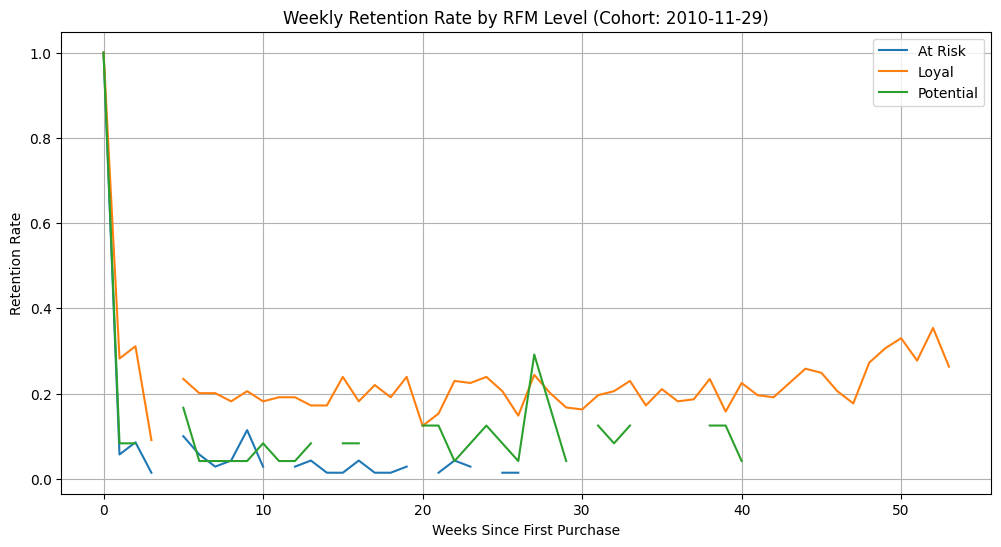

In [35]:
import matplotlib.pyplot as plt

# 示例：只画 2010-11-29 这一 cohort 周的不同 RFM_Level 的留存曲线
cohort_date = pd.to_datetime("2010-11-29")

# 筛选该 cohort 周的数据
retention_rate_reset = retention_rate.reset_index()
subset = retention_rate_reset[retention_rate_reset['cohort_week'] == cohort_date]

# 画线图
plt.figure(figsize=(12, 6))
for _, row in subset.iterrows():
    plt.plot(row.drop(['cohort_week', 'RFM_Level']), label=row['RFM_Level'])

plt.title(f"Weekly Retention Rate by RFM Level (Cohort: {cohort_date.date()})")
plt.xlabel("Weeks Since First Purchase")
plt.ylabel("Retention Rate")
plt.legend()
plt.grid(True)
plt.show()


Average retention rate by RFM segment:
RFM_Level
Loyal        0.140057
Potential    0.130113
At Risk      0.040338
dtype: float64


<Axes: title={'center': 'Average Retention Rate by RFM Segment'}, xlabel='RFM_Level', ylabel='Average Retention Rate'>

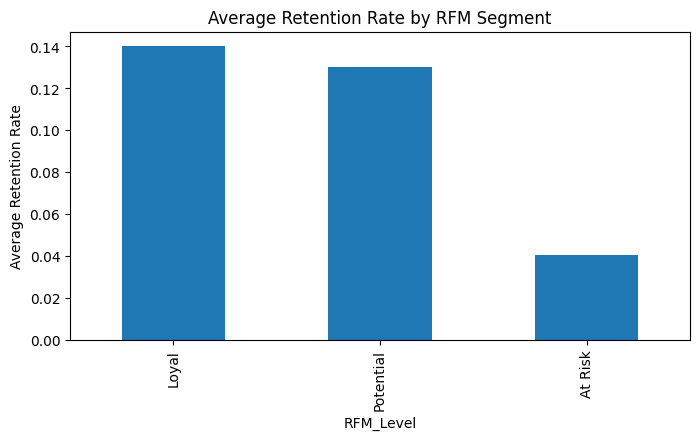

In [38]:
# 保证 retention_rate 数据还在
# 去除第0周（100%），只看后续周数留存
avg_retention_by_rfm = (
    retention_rate.drop(columns=0)  # 去掉第0周
    .groupby('RFM_Level')           # 按 RFM 分组
    .mean()                         # 计算每周平均留存率
    .mean(axis=1)                   # 再对所有周求均值，得到平均留存率
    .sort_values(ascending=False)  # 排序
)

print("Average retention rate by RFM segment:")
print(avg_retention_by_rfm)
avg_retention_by_rfm.plot(kind='bar', title='Average Retention Rate by RFM Segment', ylabel='Average Retention Rate', figsize=(8, 4))


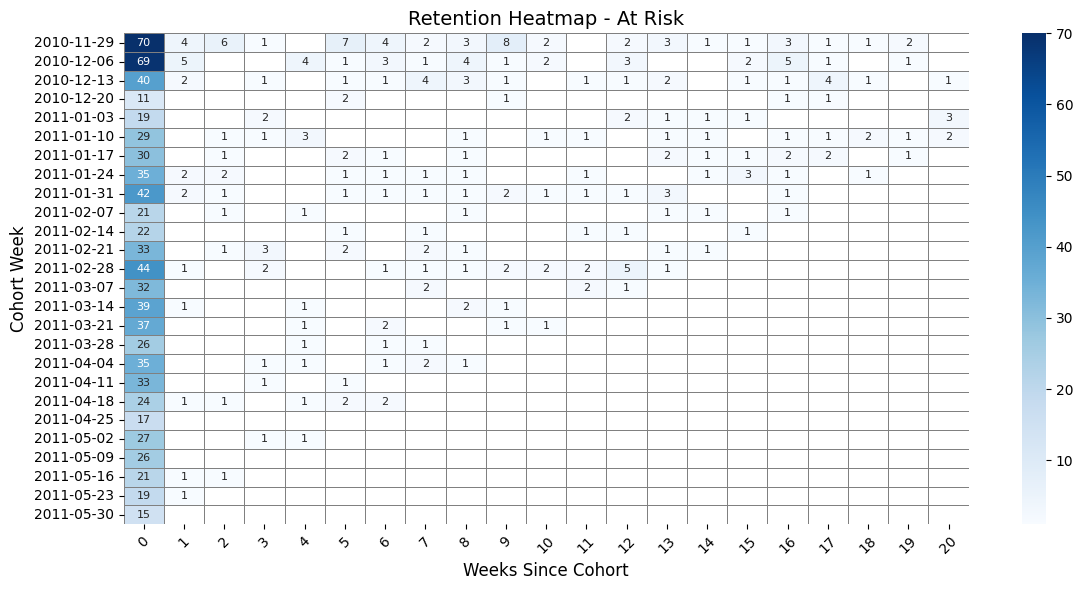

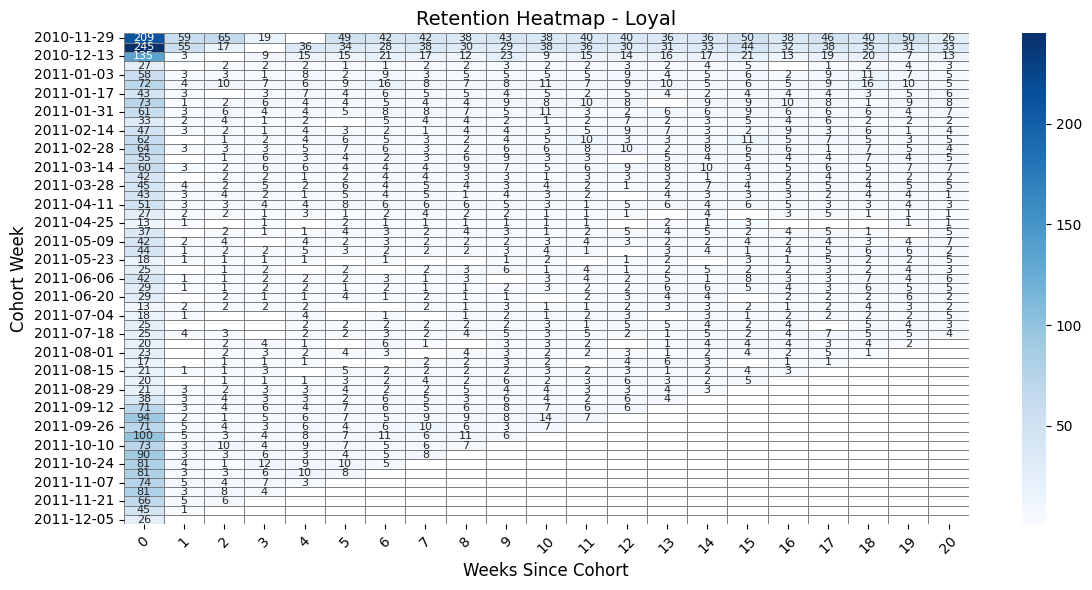

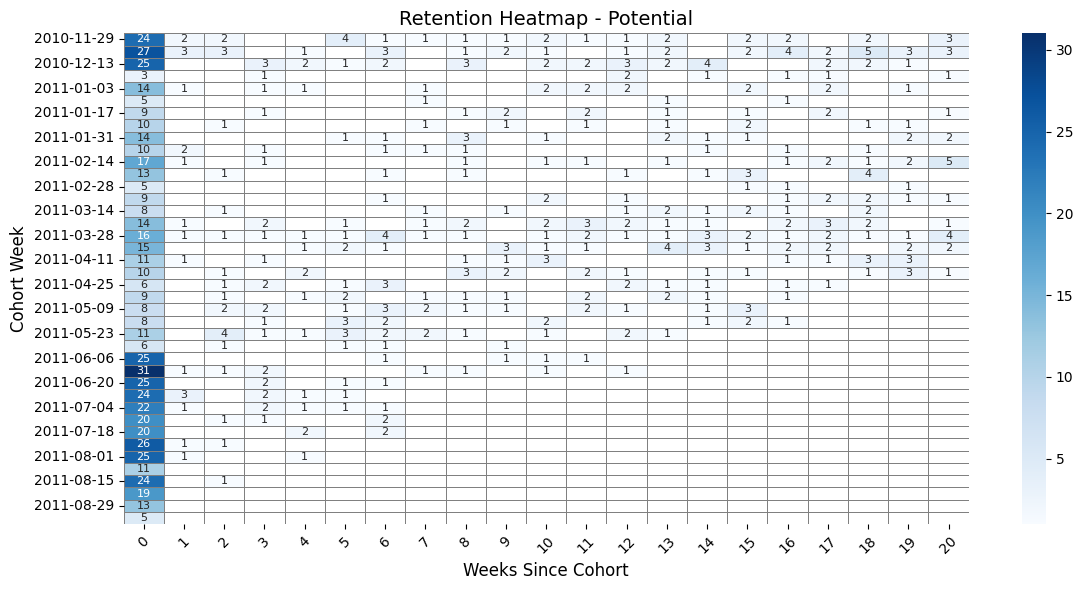

In [41]:
#画出留存热力图

import matplotlib.pyplot as plt
import seaborn as sns

# 可选：只显示前 N 周，避免图太宽
MAX_WEEKS = 20
retention_limited = retention_pivot.loc[:, :MAX_WEEKS]

# 获取所有 RFM 分组
rfm_levels = retention_limited.index.get_level_values('RFM_Level').unique()

# 遍历每个 RFM 分组并绘制图像
for level in rfm_levels:
    # 取出某一 RFM 分组的数据
    data = retention_limited.xs(level, level='RFM_Level')

    # 格式化 cohort 日期为 年-周 的格式
    data.index = data.index.to_series().dt.strftime('%Y-%m-%d')

    plt.figure(figsize=(12, 6))
    sns.heatmap(
        data,
        cmap="Blues",
        annot=True,
        fmt=".0f",
        linewidths=0.5,
        linecolor='gray',
        mask=data.isnull(),
        annot_kws={"size": 8}
    )

    plt.title(f"Retention Heatmap - {level}", fontsize=14)
    plt.xlabel("Weeks Since Cohort", fontsize=12)
    plt.ylabel("Cohort Week", fontsize=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


In [42]:
#找出最佳用户分群+cohort 周

# 平均留存率最高的组合
combo_retention = retention_rate.drop(columns=0).mean(axis=1).sort_values(ascending=False)
best_combo = combo_retention.head(1)
print("平均留存最高的分群 + 首购周：")
print(best_combo)


平均留存最高的分群 + 首购周：
cohort_week  RFM_Level
2010-12-20   Potential    0.36664
dtype: float64
